In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import os
import sys
import re
import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors


sys.path.append(
    os.path.abspath(
        os.path.expanduser(
            '~/CNN-MARL_closure_model_discovery')))


from xlb_flows.utils import vorticity_2d, energy_spectrum_2d

In [3]:
#plotting utils 
# Custom sorting key
def custom_sort_key(folder):
    match = re.search(r'N(\d+)_', folder)
    if match:
        N = int(match.group(1))
        return (0 if N < 2048 else 1, N)
    return (1, 0)

# Custom sorting key names
def custom_sort_key_names(folder):
    match = re.search(r'(\d+)_', folder)
    if match:
        N = int(match.group(1))
        return (0 if N < 2048 else 1, N)
    return (1, 0)

# get all filenames in directory
def get_names(path):
    files = os.listdir(path)
    return np.sort(files)


def plot_correlations(corrs, names, N, M):
    t = np.linspace(0, 227, M)
    idex = np.argmin(np.abs(t - 26))
    their_t = t/16
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    for i in range(N-1):
        plt.plot(t, corrs[:,i], label=names[i])
    plt.plot(t, corrs[:,N-1], 'k--', label=names[N-1])
    plt.xlabel(r'non-dimensional time $T = (U/L)t$')
    plt.ylabel(r'vorticity correlation with DNS')
    plt.legend(loc='best')
    plt.show()


def plot_spectra(spec_mean, spec_std, k, names, N):
    # plot the averaged spectrum
    plt.figure(figsize=(10,6), dpi=300)
    plt.set_cmap('cool')
    for i in range(N-1):
        plt.loglog(spec_mean[i,...]*k**5, label=names[i])
        plt.fill_between(k,
                         spec_mean[i,...]*k**5 - spec_std[i,...]*k**5,
                         spec_mean[i,...]*k**5 + spec_std[i,...]*k**5,
                         alpha=0.3
                         )
    plt.loglog(spec_mean[-1,...]*k**5,
               'k--',
               label=names[-1]
               )
    plt.fill_between(k,
                     (k**5)*(spec_mean[-1,...]-spec_std[-1,...]),
                     (k**5)*(spec_mean[-1,...] + spec_std[-1,...]), 
                     alpha=0.3,
                     color='k'
                     )
    plt.ylabel(r'Energy spectrum $E(k)k^5$')
    plt.xlabel(r'wavenumber $k$')
    plt.legend()
    plt.show()  

    # plot the averaged spectrum
    plt.figure(figsize=(10,6), dpi=300)
    plt.set_cmap('cool')
    for i in range(N-1):
        plt.loglog(spec_mean[i,...], label=names[i])
        plt.fill_between(k,
                         spec_mean[i,...]-spec_std[i,...],
                         spec_mean[i,...] + spec_std[i,...],
                         alpha=0.3
                         )
    plt.loglog(spec_mean[-1,...],
               'k--',
               label=names[-1]
               )
    plt.fill_between(k,
                     spec_mean[-1,...]-spec_std[-1,...],
                     spec_mean[-1,...] + spec_std[-1,...],
                     alpha=0.3,
                     color='k'
                     )
    #plt.loglog(1e2*k**(-5.), label="k^-5/3", linestyle="--")
    plt.ylabel(r'Energy spectrum $E(k)$')
    plt.xlabel(r'wavenumber $k$')
    plt.legend()
    plt.show()


def create_plots(test_directory):
    # Get all folder names within `test_directory`
    subfolders = [name for name in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, name))]
    subfolders = np.sort(subfolders)

    # Sort folders with custom key
    subfolders = sorted(subfolders, key=custom_sort_key)
    
    # Extract names={N}_{model} from each folder name
    #names = []
    #for folder in subfolders:
    #    match = re.search(r'N(\d+)_S\d+_U\d+_(\w+)', folder)
    #    if match:
    #        N = match.group(1)
    #        model = match.group(2)
    #        names.append(f"{N}_{model}")
    #
    #names = sorted(names, key=custom_sort_key_names)
    names = ["128_BGK",
             "128_glob",
             "128_interp",
             "128_loc",
             "128_KBC",
             "256_BGK",
             "2048_BGK"]

    paths = [test_directory+subfolder+"/" for subfolder in subfolders]

    #load all velocity files for all paths, and compute vorticity correlation
    images = [get_names(path) for path in paths]
    N = len(paths)
    M = len(images[0])-1
    corrs = np.zeros((M,N))
    print("computing vorticity correlations:")
    for i in tqdm(range(M)):
        #load all velocities 
        velocities = np.array([np.load(paths[j]+'/'+images[j][i]) for j in range(N)])
        vorticities = np.array([vorticity_2d(velocities[j,...], 2.0*np.pi/128) for j in range(N)])
        corrs[i,...] = np.array([np.corrcoef(vorticities[j,...].flatten(), vorticities[-1,...].flatten())[0, 1] 
                                 for j in range(N)])
    #plot correlations
    plot_correlations(corrs, names, N, M)

    #compute enerty spectrum statistics
    L = int(128/2 - 1)
    a = 1*M//2 #1*M//2
    b = M-1
    spec = np.zeros((N, L, (b-a)))
    k = np.arange(L)
    # loop over all files in files1 between a and b and add to spec
    print("computing energy spectra:")
    for i in tqdm(range(a, b)):
        velocities = np.array([np.load(paths[j]+'/'+images[j][i]) for j in range(N)])
        for j in range(N):
            _, spec[j,:,i-a] = energy_spectrum_2d(velocities[j,...])
    spec_mean=spec.mean(axis=-1)
    spec_std=spec.std(axis=-1)

    # plot spectra
    plot_spectra(spec_mean, spec_std, k, names, N)


    # plot vorticity fields
    f_size = 10

    # Sample time steps for demonstration
    ts = np.array([0, 1/3, 2/3, 1]) * (M-2)
    time_labels = np.array([0, 1/3, 2/3, 1]) * (227)

    # Plot vorticity images at times t1 to t5 for all resolutions
    fig, axs = plt.subplots(N, 4, figsize=(4.2, N+1), dpi=300)

    for i in range(4):
        for j in range(N):
            u = np.load(paths[j] + '/' + images[j][int(ts[i])]) 
            v = vorticity_2d(u, 2.0 * np.pi / 128)       
            axs[j, i].imshow(v, vmin=-10, vmax=10, cmap=sns.cm.icefire)
            axs[j, i].set_xticks([])  # Disable x-ticks
            axs[j, i].set_yticks([])  # Disable y-ticks

    # Add row labels
    for i, ax in enumerate(axs[:, 0]):
        ax.set_ylabel(f"{names[i]}", fontsize=f_size)

    # Add time labels to each column
    for i, ax in enumerate(axs[0, :]):
        ax.set_title(f"t={time_labels[i]:.1f}", fontsize=f_size)

    # Set up the colorbar with continuous color gradient, arrowed edges, and specified ticks
    vmin, vmax = -10, 10
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust to span entire height
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=sns.cm.icefire, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, extend='both', extendfrac=0.07, aspect=10)  # Extend arrows and adjust aspect ratio
    cbar.set_label('Vorticity', fontsize=f_size)
    cbar.ax.tick_params(labelsize=f_size)

    # Set 5 evenly spaced ticks on the colorbar
    cbar.set_ticks(np.linspace(vmin, vmax, 5))

    # Adjust spacing between subplots
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.06, hspace=0.015)

    plt.show()


computing vorticity correlations:


100%|██████████| 626/626 [00:02<00:00, 288.78it/s]


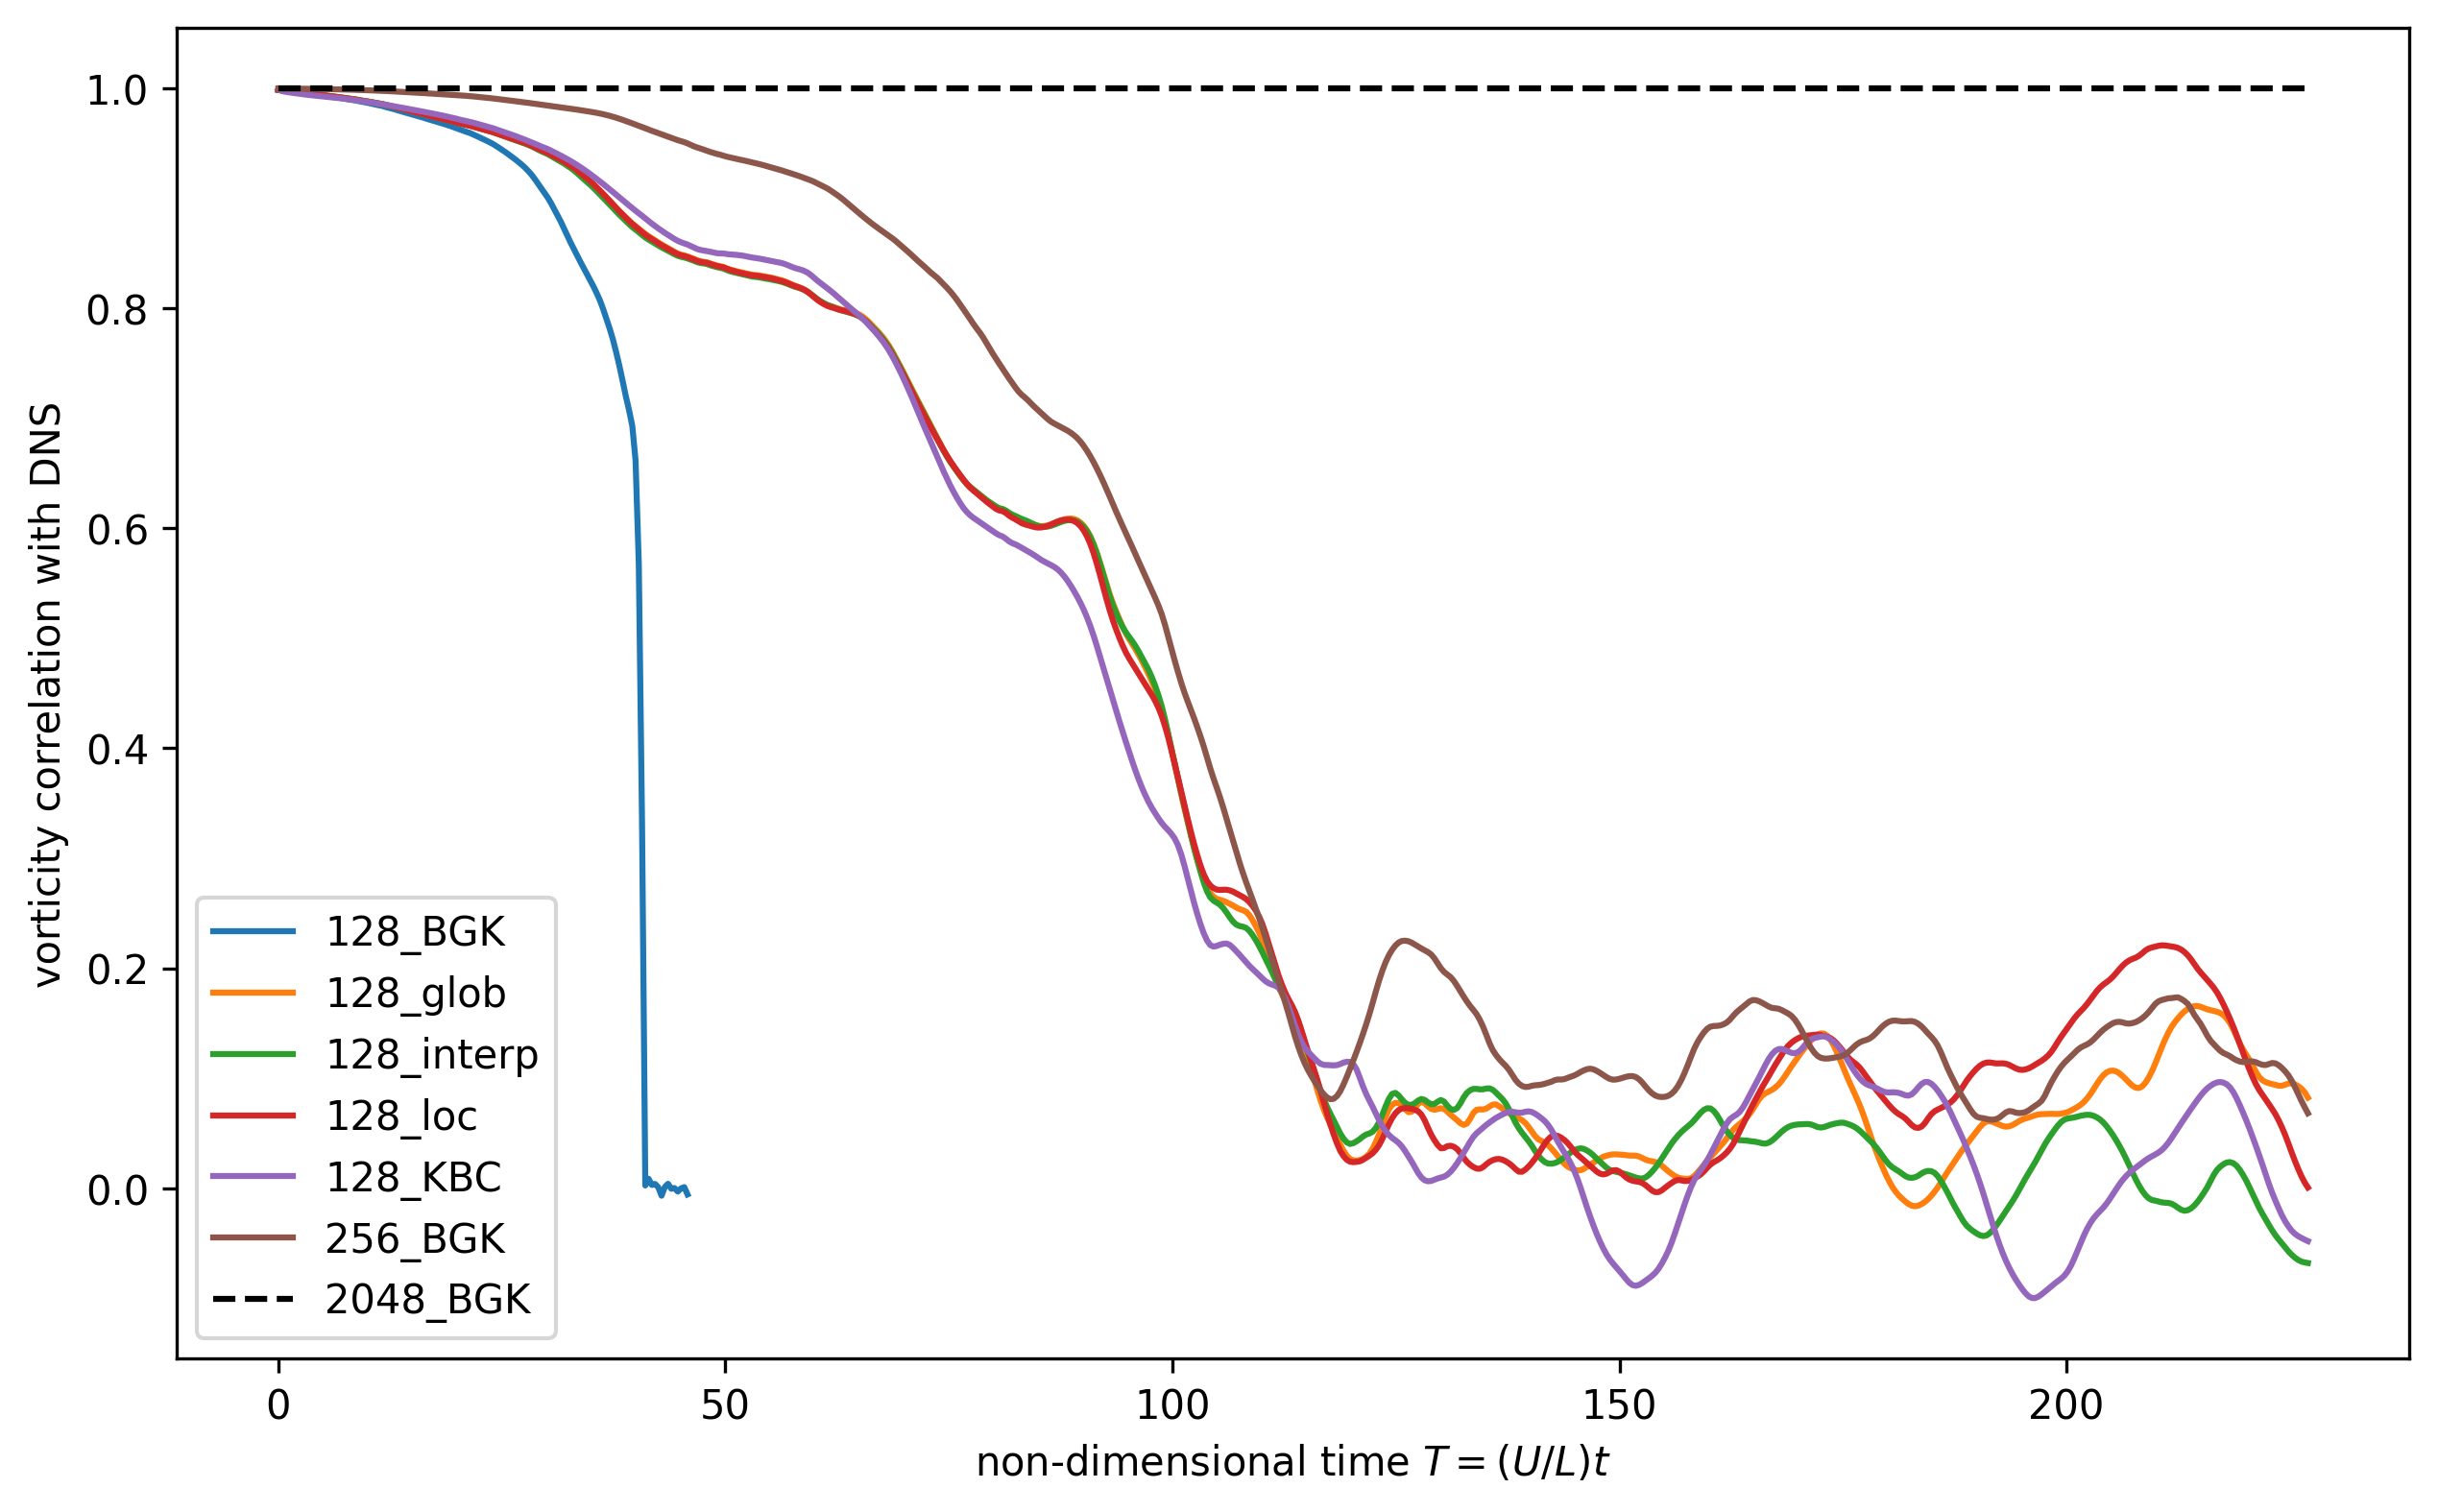

computing energy spectra:


100%|██████████| 312/312 [00:05<00:00, 56.66it/s]


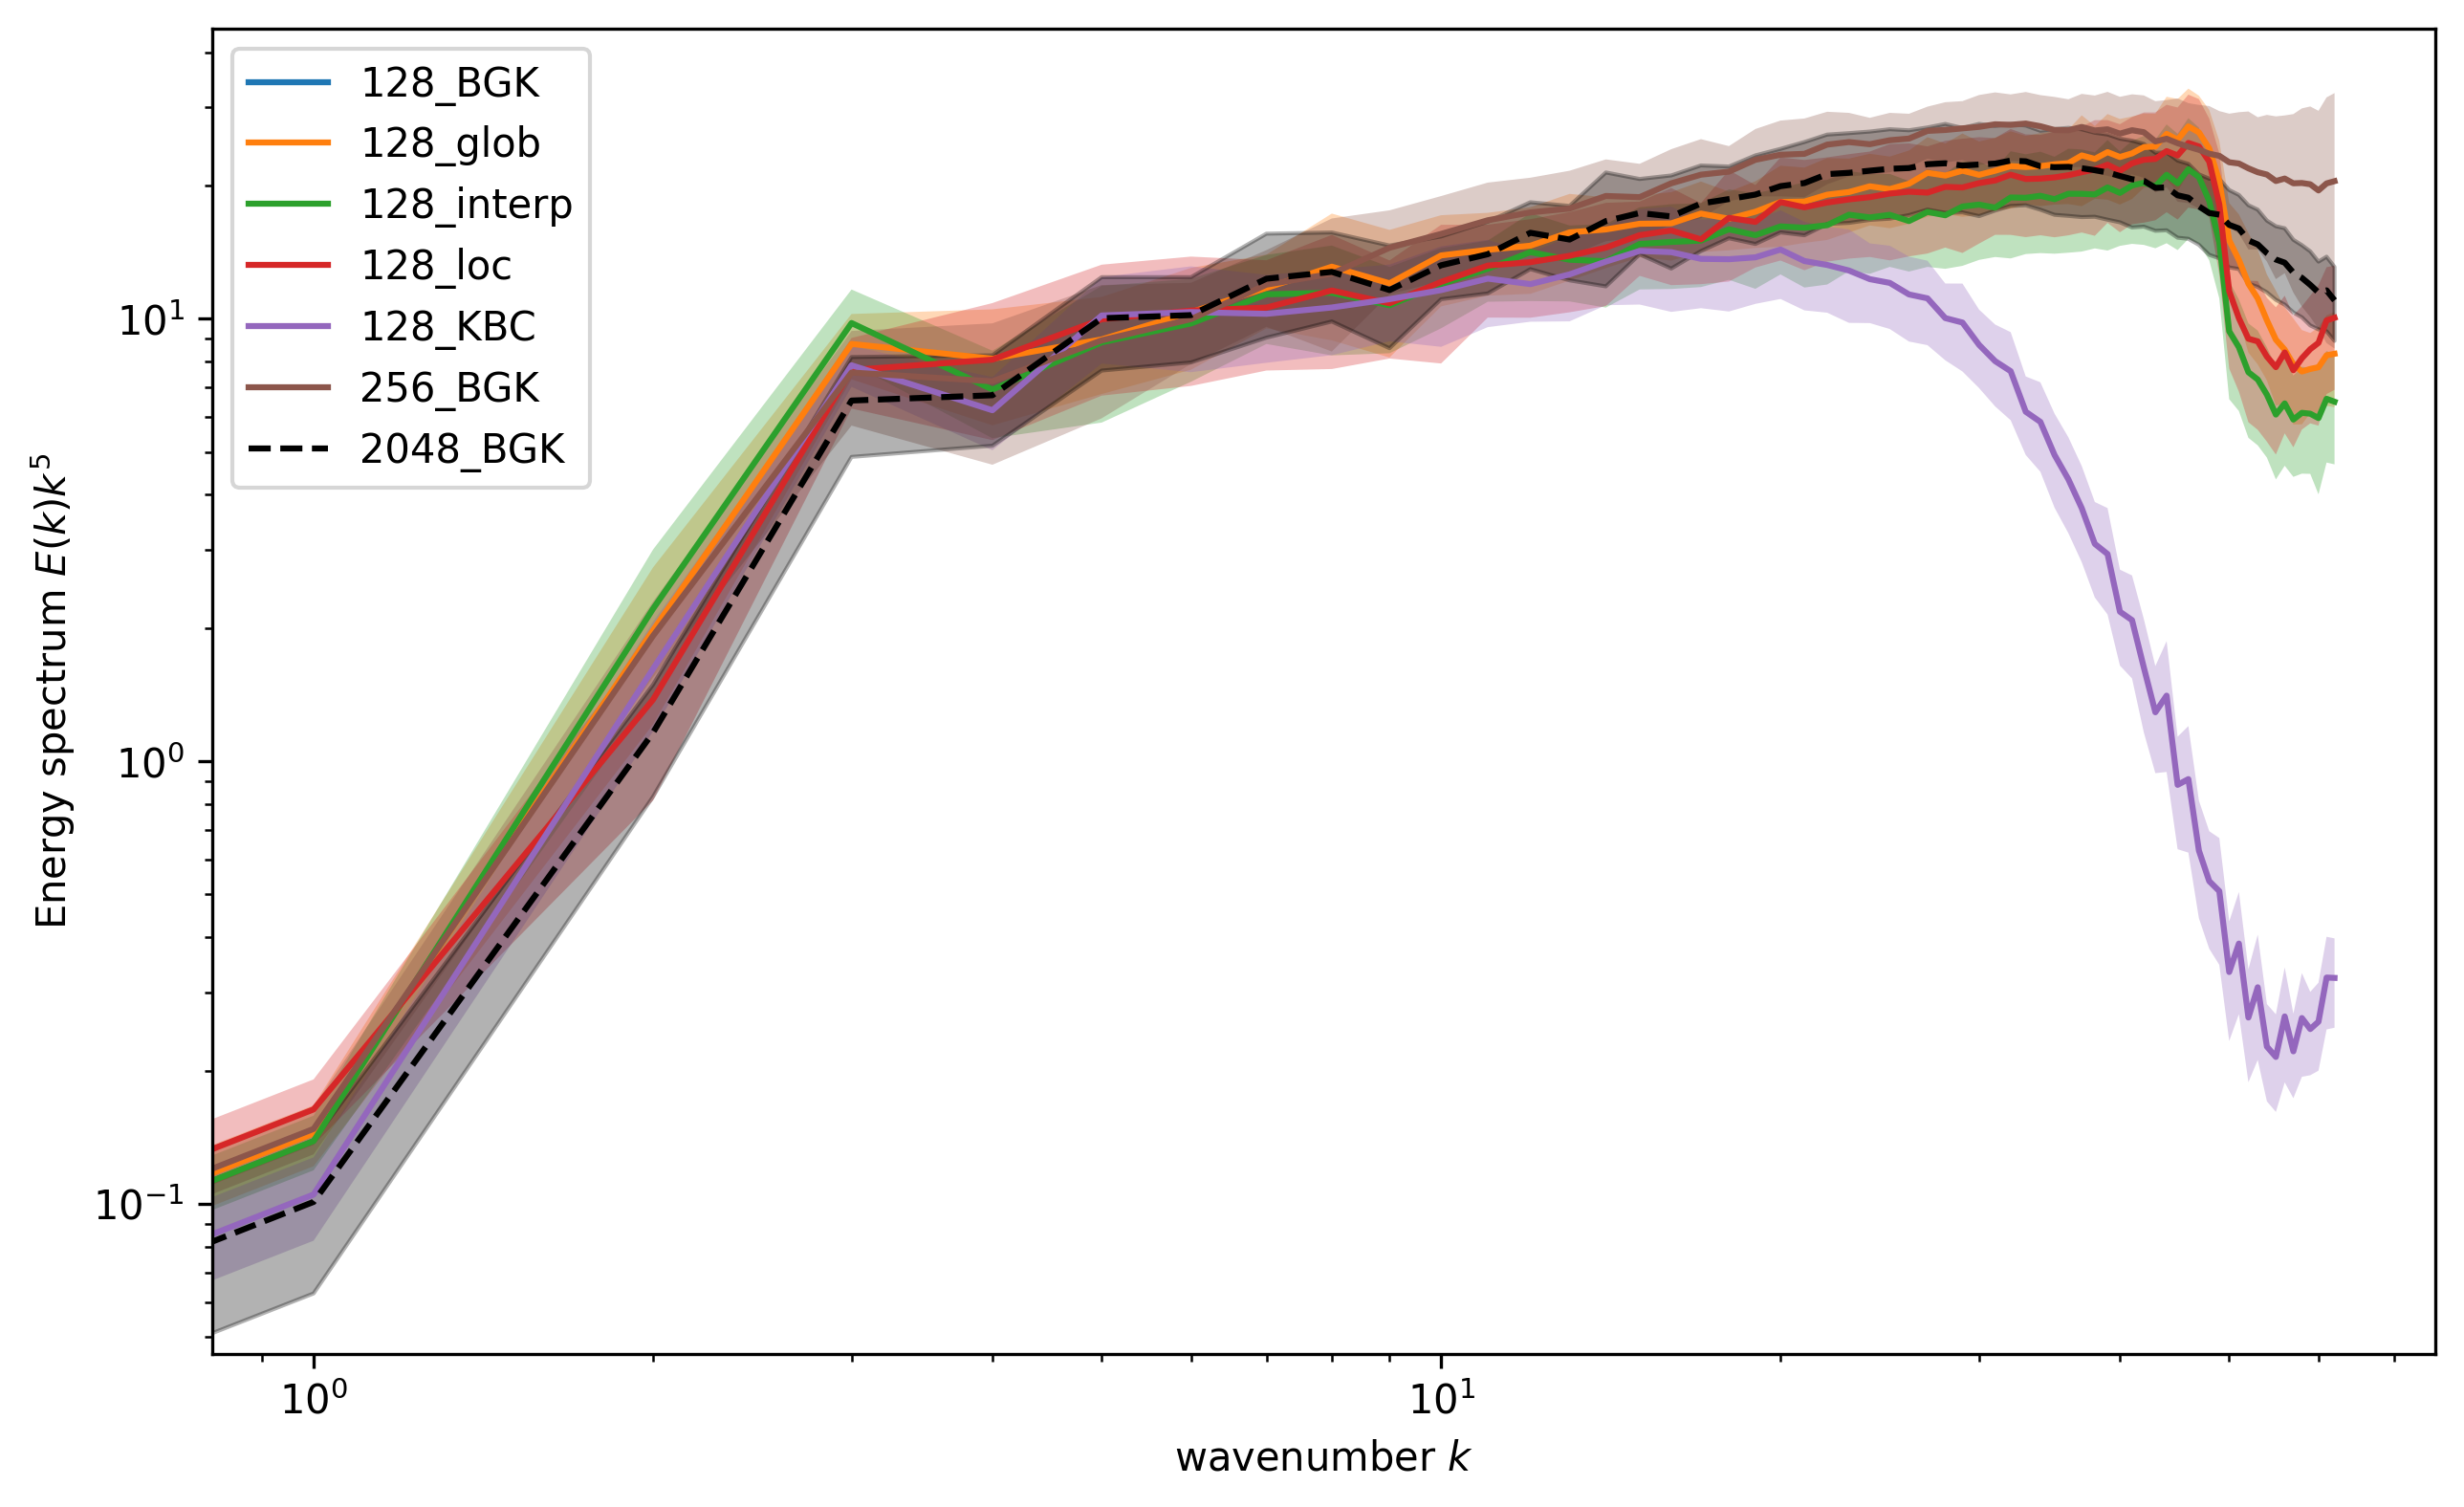

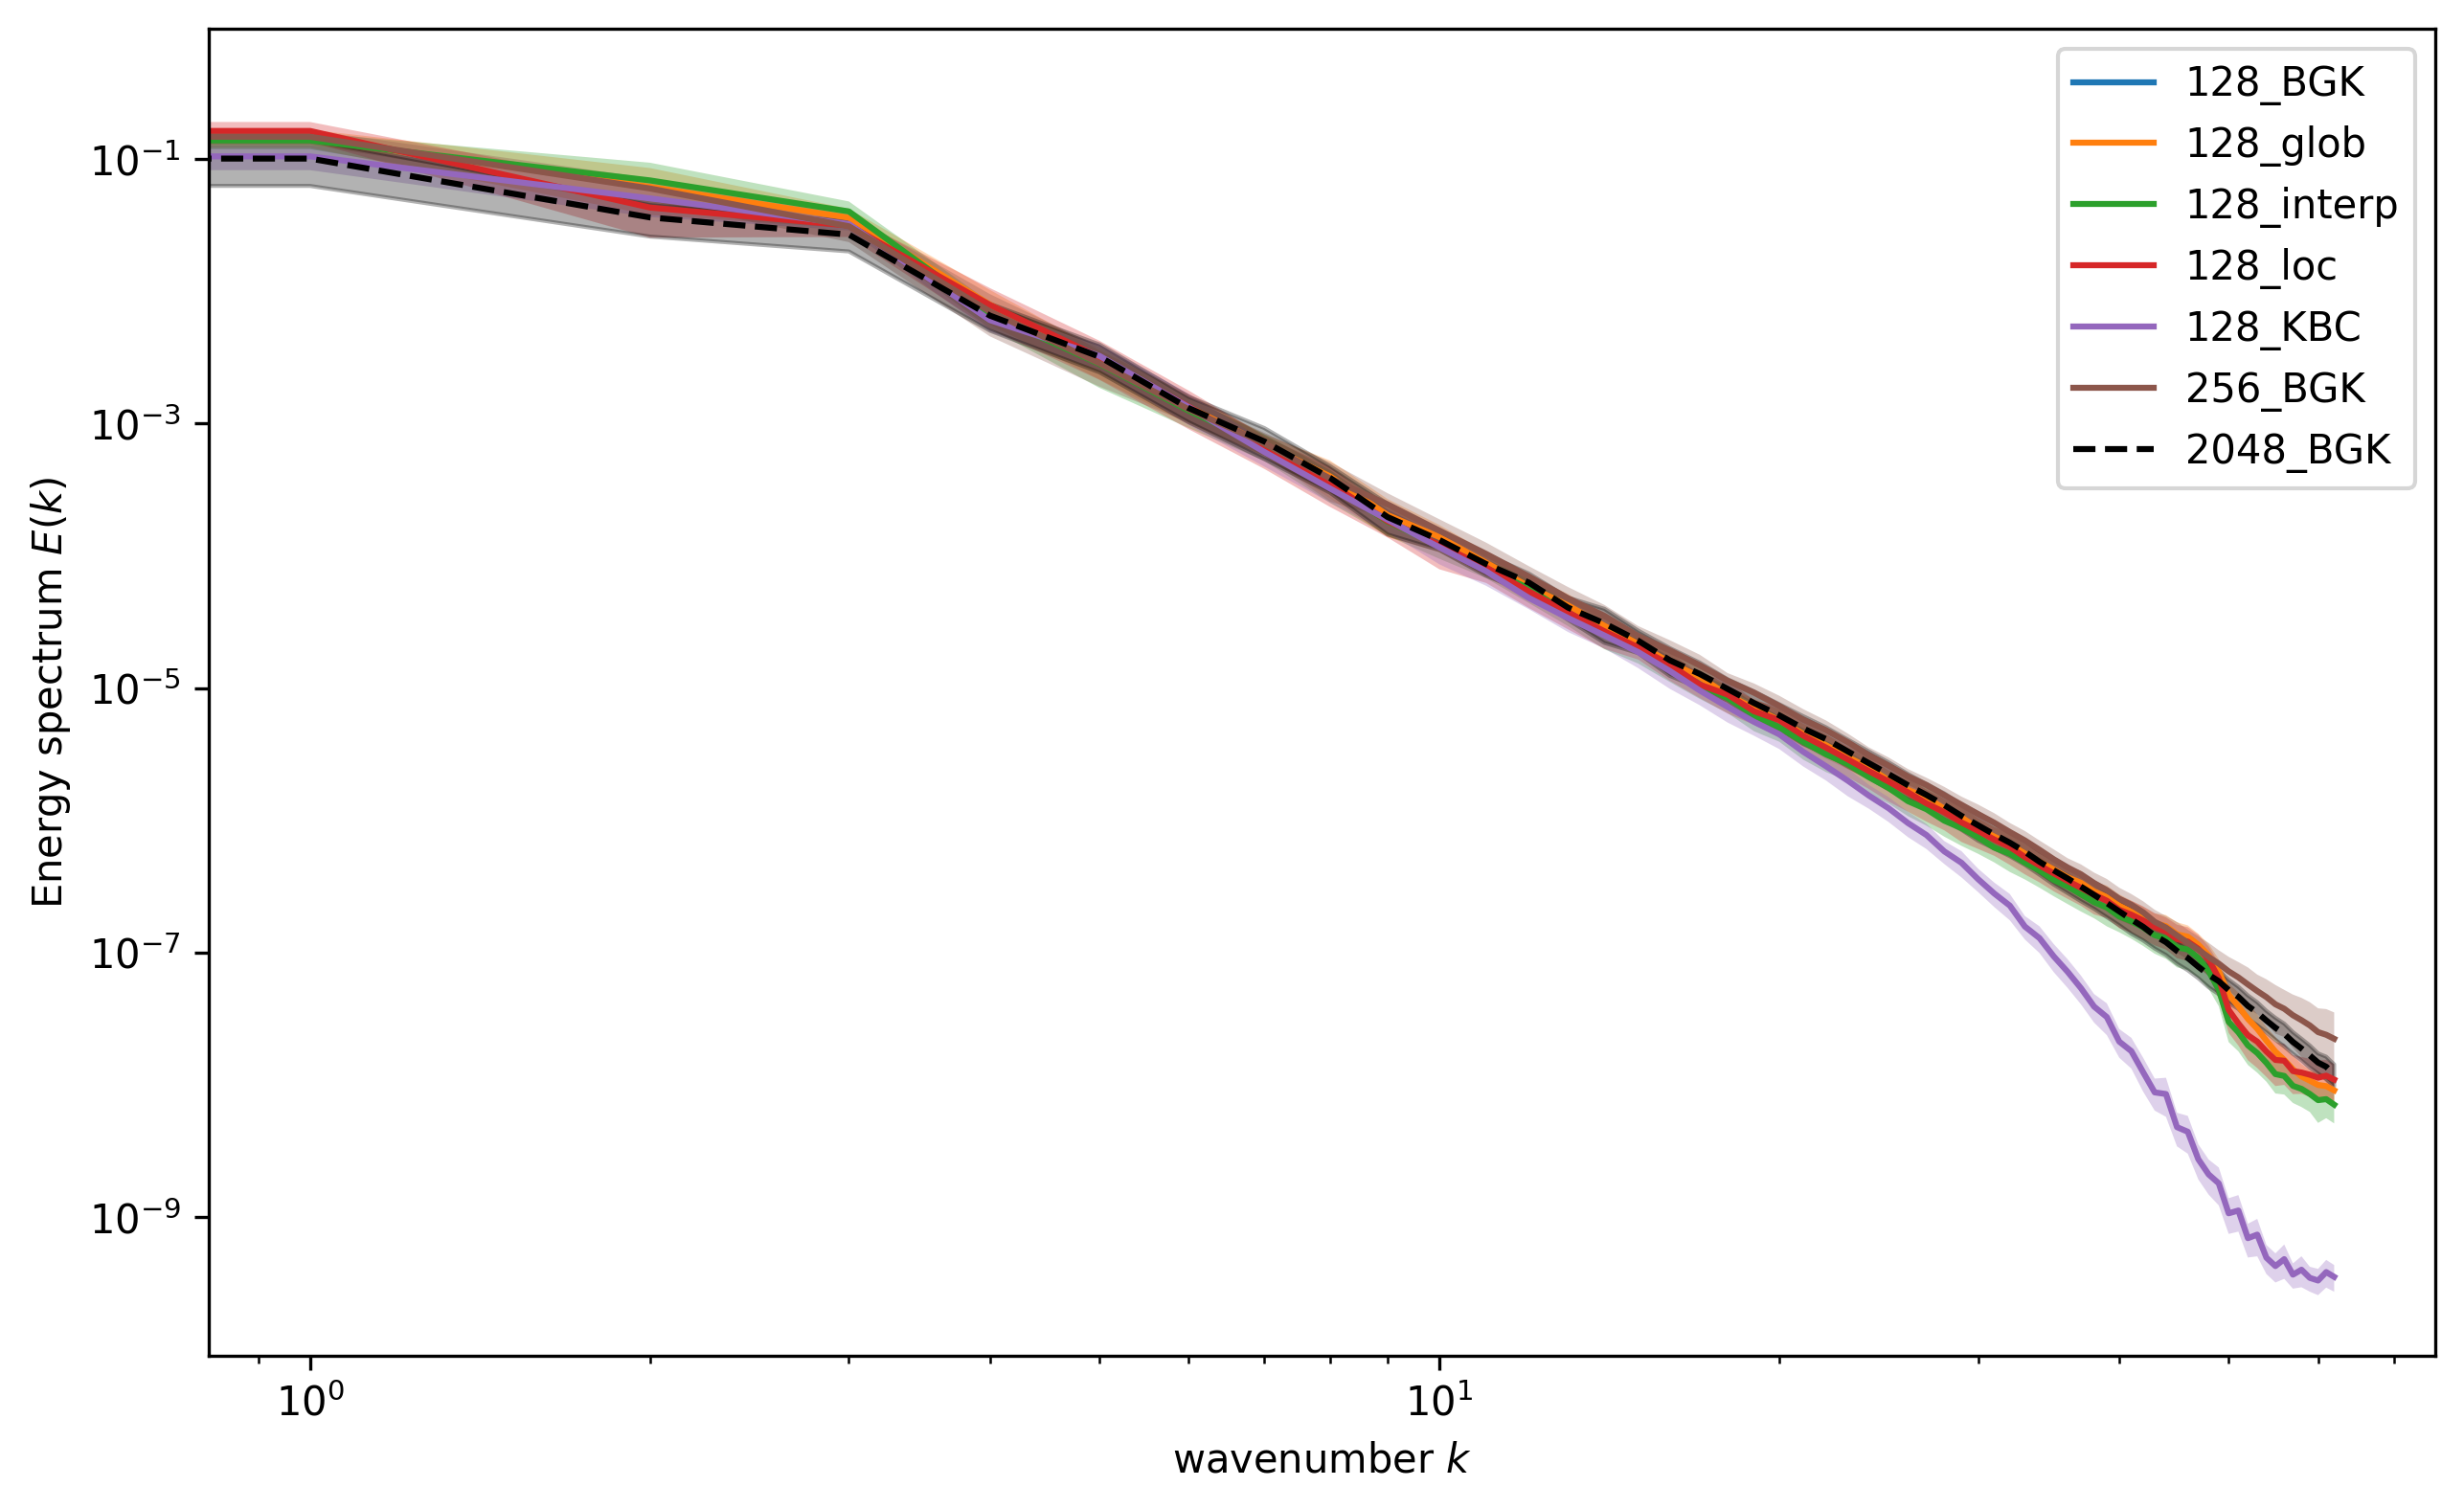

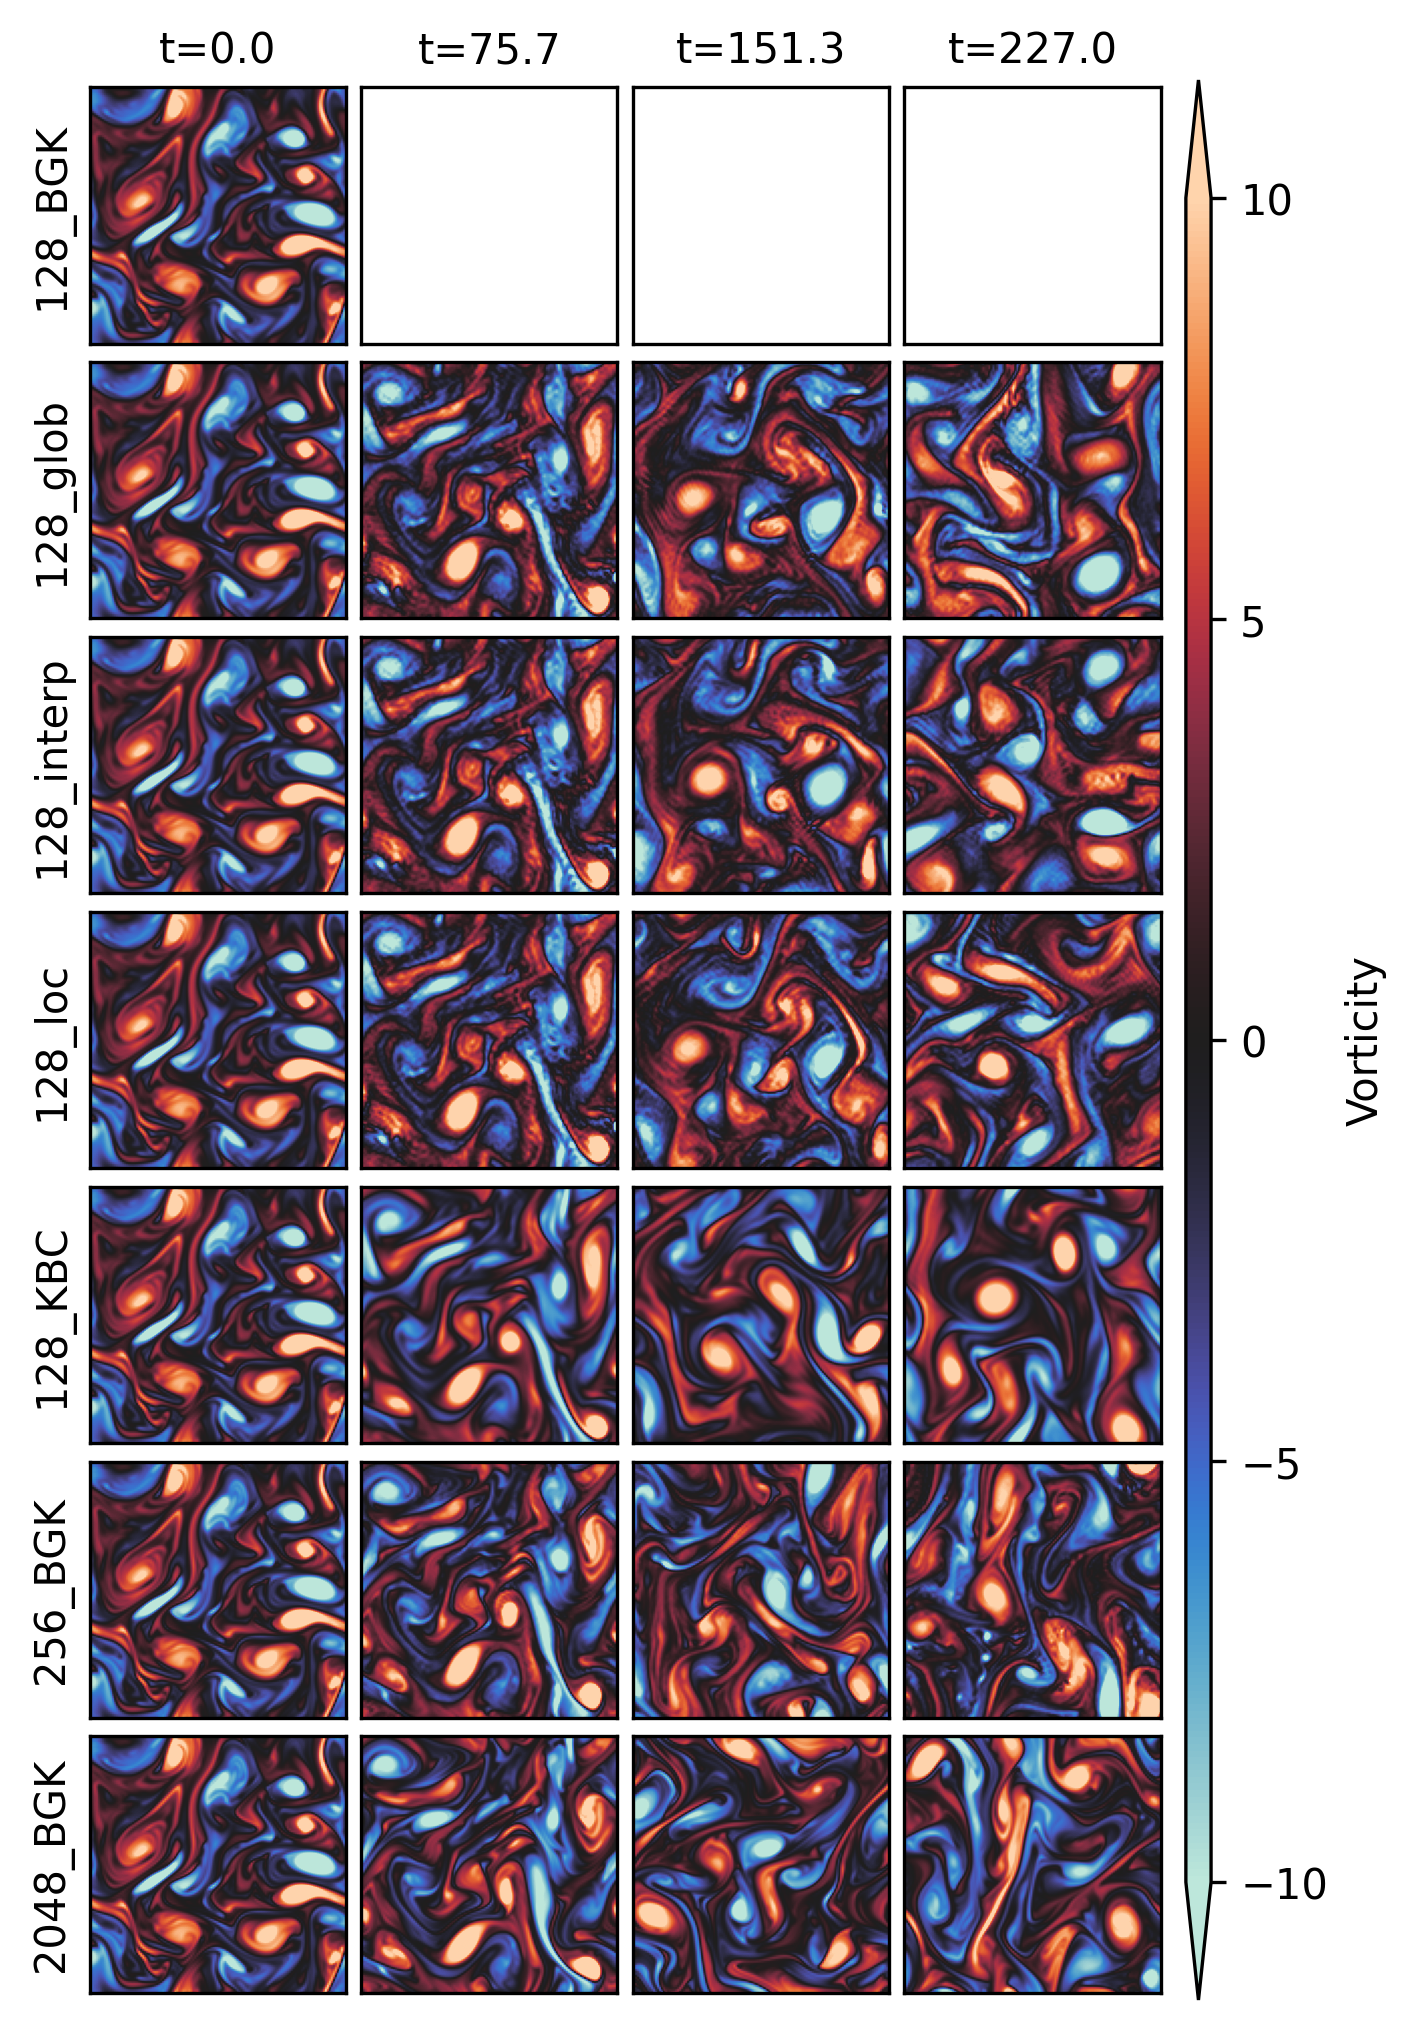

In [5]:
create_plots('re10000_T227_S33_Kolmogorov_runs/')

## Visualize models

In [23]:
# Create plots for GIF of loc vs cgs vs dns
def plot_vorticity_and_spectra(v1, v2, v3, spec1, spec2, spec3, i):
    # Define figure and grid layout
    fig = plt.figure(figsize=(16, 5))
    gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 1], wspace=0.2)

    # Vorticity plots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])  # Energy spectrum plot

    # Plot the vorticity data
    im1 = ax1.imshow(v1, vmin=-10, vmax=10, cmap=sns.cm.icefire)
    ax2.imshow(v2, vmin=-10, vmax=10, cmap=sns.cm.icefire)
    ax3.imshow(v3, vmin=-10, vmax=10, cmap=sns.cm.icefire)

    # Add a colorbar styled to match the given example
    vorticity_cbar_ax = fig.add_axes([
        ax1.get_position().x0 - 0.04,  # Position to the left of the first image
        ax1.get_position().y0,        # Match the bottom of the vorticity plots
        0.02,                         # Fixed width for the colorbar
        ax1.get_position().height     # Match the height of the images
    ])
    norm_vorticity = mcolors.Normalize(vmin=-10, vmax=10)
    sm_vorticity = plt.cm.ScalarMappable(cmap=sns.cm.icefire, norm=norm_vorticity)
    cbar_vorticity = fig.colorbar(
        sm_vorticity,
        cax=vorticity_cbar_ax,
        extend='both',
        extendfrac=0.07,
        aspect=10
    )
    # Adjust ticks and label to the left
    cbar_vorticity.ax.yaxis.tick_left()
    cbar_vorticity.ax.yaxis.set_label_position('left')
    cbar_vorticity.ax.tick_params(labelsize=10)
    cbar_vorticity.set_ticks(np.linspace(-10, 10, 3))
    cbar_vorticity.set_label("Vorticity", fontsize=12, labelpad=10)

    # Titles for vorticity plots
    ax1.set_title("128_BGK", fontsize=12)
    ax2.set_title("128_ReLBM", fontsize=12)
    ax3.set_title("2048_BGK", fontsize=12)

    # Hide axis ticks for vorticity plots
    for ax in [ax1, ax2, ax3]:
        ax.set_xticks([])
        ax.set_yticks([])

    # Energy spectrum plot
    ax4.loglog(spec1, label="128_BGK", color='#1f77b4')
    ax4.loglog(spec2, label="128_ReLBM", color='#d62728')
    ax4.loglog(spec3, label="2048_BGK", color="black", linestyle="--")
    ax4.legend(fontsize=12)
    ax4.set_title("Energy Spectrum", fontsize=12)
    ax4.set_xlabel("Wavenumber k", fontsize=12)
    ax4.set_ylabel("Energy E(k)", fontsize=12)
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position('right')
    ax4.tick_params(axis='both', which='major', labelsize=12)

    # Adjust the aspect ratio of all axes to ensure consistent sizes
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_box_aspect(1)  # Ensures square plots for consistency

    plt.tight_layout()
    plt.savefig(f"visuals/img{i}.png", dpi=100)
    plt.close()


In [24]:
cgs_path = "re10000_T227_S33_Kolmogorov_runs/re10000_T227_N128_S33_U1_BGK/"
loc_path = "re10000_T227_S33_Kolmogorov_runs/re10000_T227_N128_S33_U1_ClosureRL-loc/"
fgs_path = "re10000_T227_S33_Kolmogorov_runs/re10000_T227_N2048_S33_U1_BGK/"
#get velocitiy fields from folders
cgs_vel = get_names(cgs_path)
loc_vel = get_names(loc_path)
fgs_vel = get_names(fgs_path)

M = len(fgs_vel)-1

In [25]:
if not os.path.exists('visuals'):
    os.makedirs('visuals')

# Main loop
for i in tqdm(range(M)):
    #if i % 100 == 0:
        u1 = np.load(os.path.join(cgs_path, cgs_vel[i]))
        v1 = vorticity_2d(u1, 2.0*np.pi/128)
        _, spec1 = energy_spectrum_2d(u1)

        u2 = np.load(os.path.join(loc_path, loc_vel[i]))
        v2 = vorticity_2d(u2, 2.0*np.pi/128)
        _, spec2 = energy_spectrum_2d(u2)

        u3 = np.load(os.path.join(fgs_path, fgs_vel[i]))
        v3 = vorticity_2d(u3, 2.0*np.pi/128)
        _, spec3 = energy_spectrum_2d(u3)

        plot_vorticity_and_spectra(v1, v2, v3, spec1, spec2, spec3, i)

  0%|          | 0/626 [00:00<?, ?it/s]/tmp/ipykernel_3155495/1268509460.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
100%|██████████| 626/626 [06:30<00:00,  1.60it/s]


## Energy spectrum plot

In [26]:
test_directory = 're10000_T227_S33_Kolmogorov_runs/'

subfolders = [name for name in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, name))]
subfolders = np.sort(subfolders)

# Sort folders with custom key
subfolders = sorted(subfolders, key=custom_sort_key)

names = ["128_BGK",
         "128_glob",
         "128_interp",
         "128_loc",
         "128_KBC",
         "256_BGK",
         "2048_BGK"]

paths = [test_directory+subfolder+"/" for subfolder in subfolders]

#load all velocity files for all paths, and compute vorticity correlation
images = [get_names(path) for path in paths]
N = len(paths)
M = len(images[0])-1


#compute enerty spectrum statistics
L = int(128/2 - 1)
a = 1*M//2 #1*M//2
b = M-1
spec = np.zeros((N, L, (b-a)))
k = np.arange(L)


scaled_spec = np.zeros((L-1, (b-a)))
spec = np.zeros((L-1, (b-a)))
for i in tqdm(range(a, b)):
    velocities = np.array(np.load(paths[-1]+'/'+images[-1][i]))
    for j in range(N):
        _, E = energy_spectrum_2d(velocities)
        scaled_spec[:,i-a] = np.log((E[1:]*k[1:]**5))/10
        spec[:,i-a] = E[1:]

scaled_std = spec.std(axis=-1)
scaled_std_posterior = np.log((scaled_std*k[1:]**5))/10

100%|██████████| 312/312 [00:06<00:00, 51.00it/s]


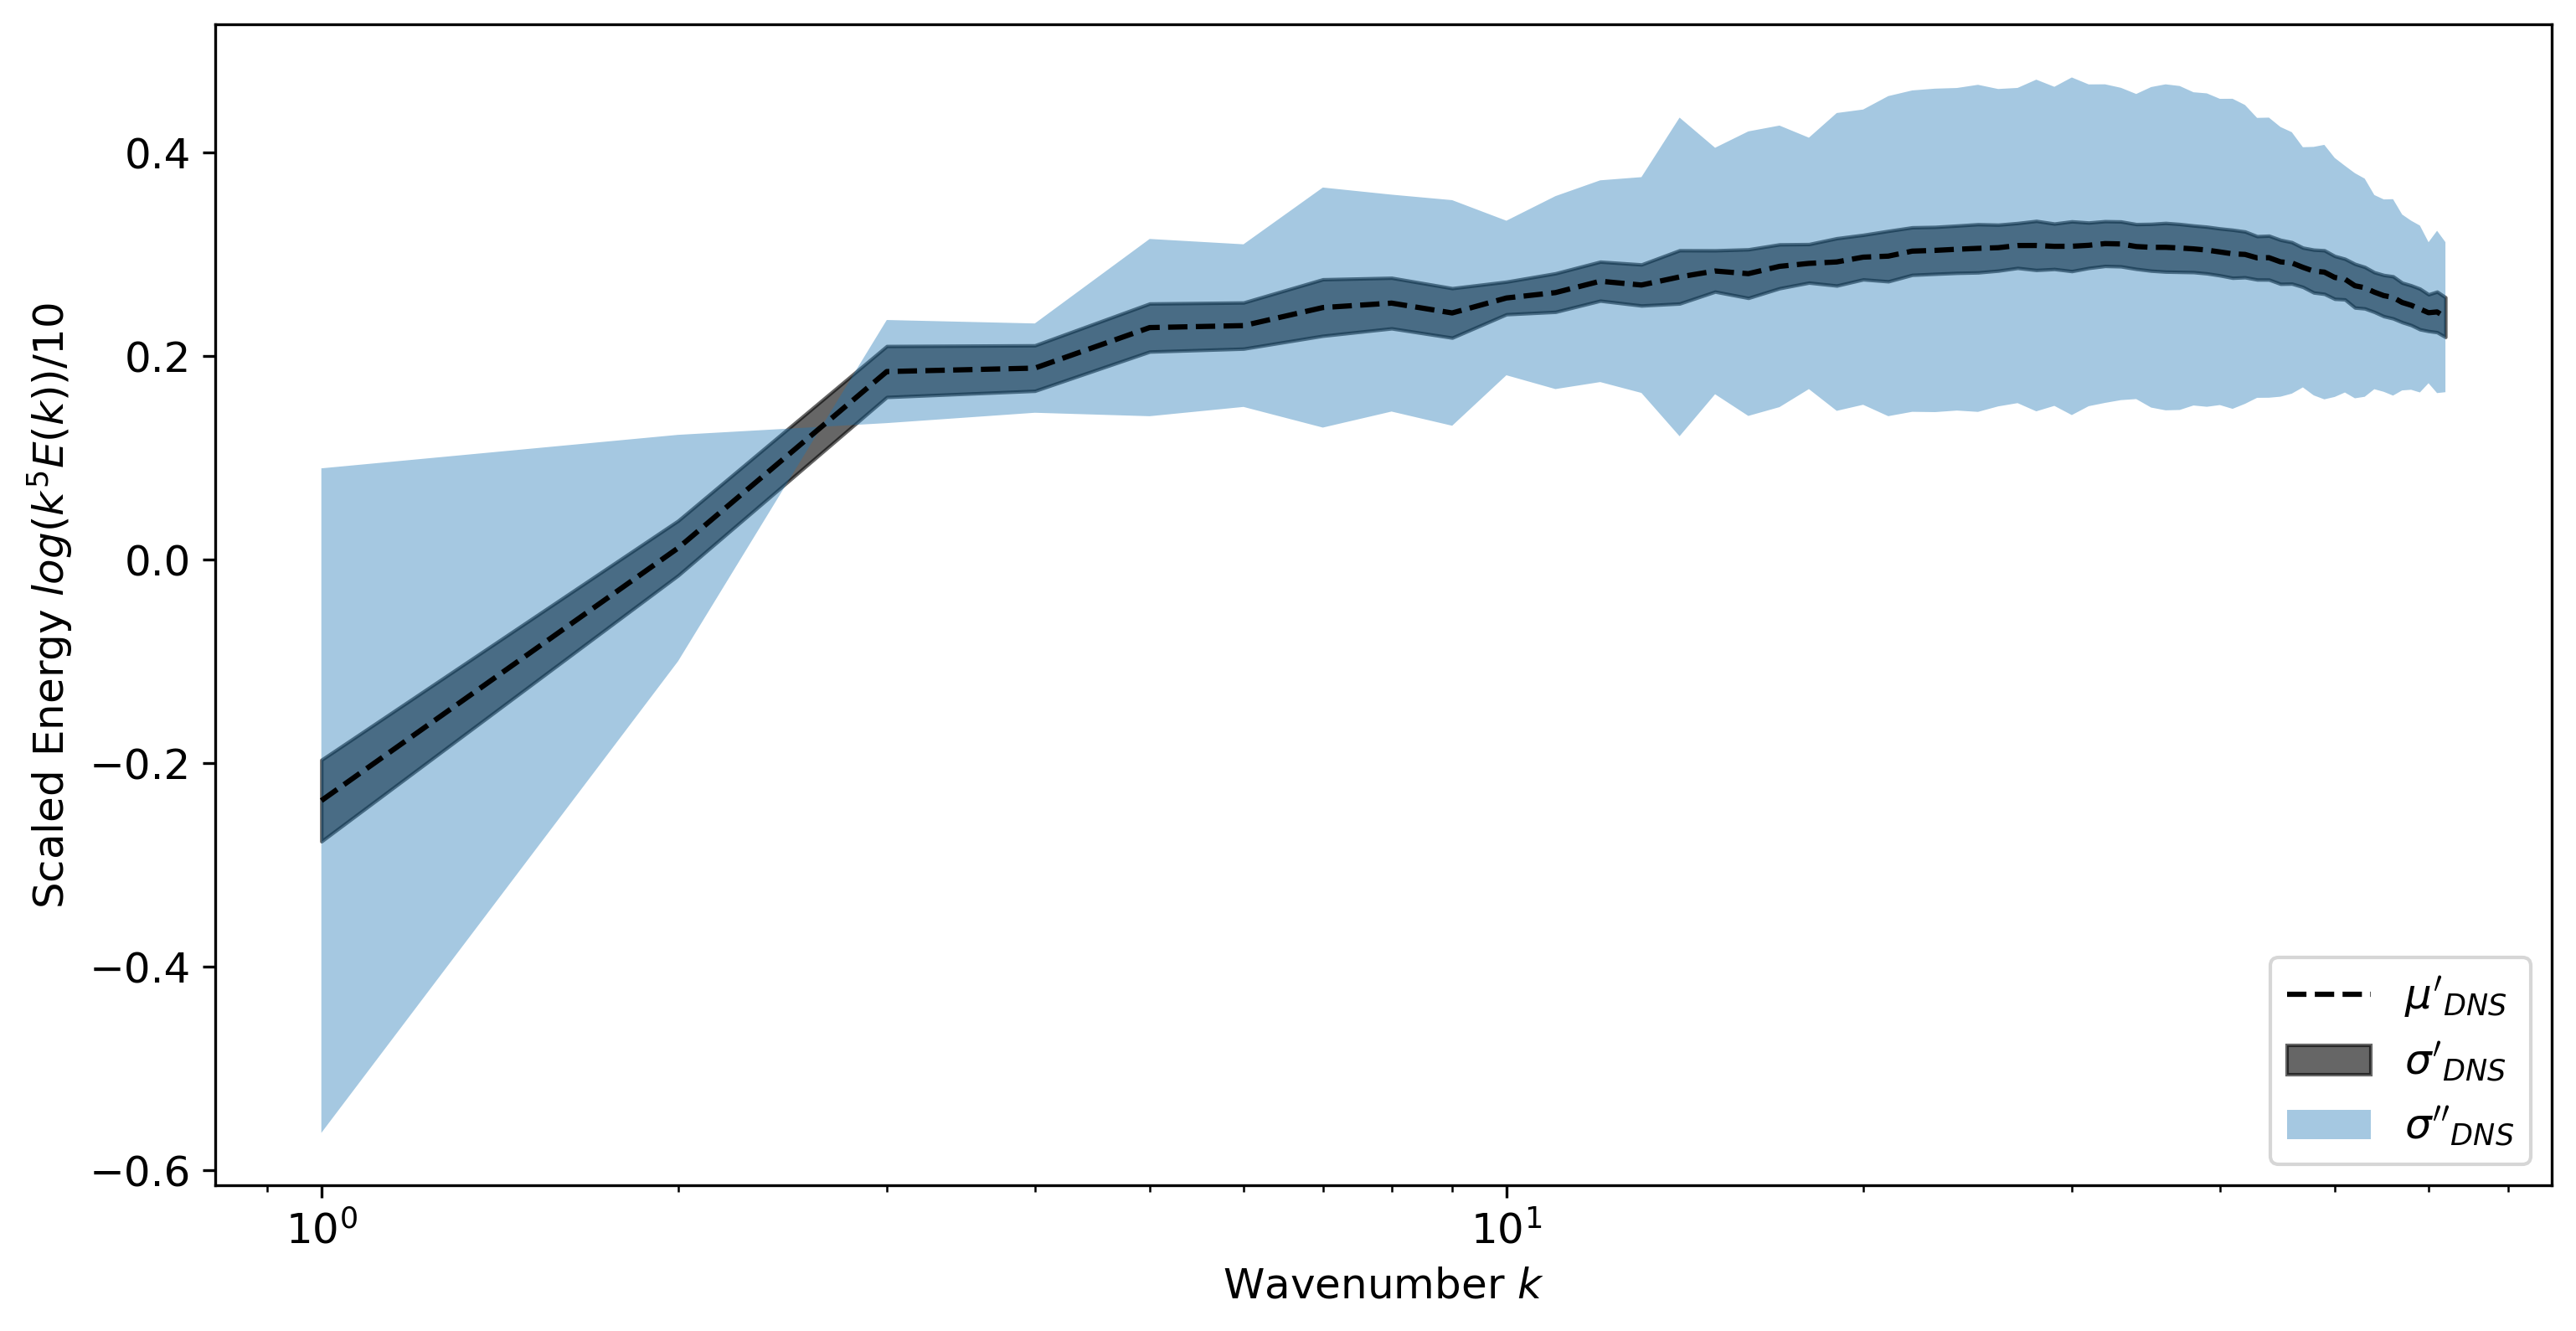

In [34]:
# Set global font size
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(12, 6), dpi=300)
k = np.linspace(1, scaled_spec.shape[0], scaled_spec.shape[0])

# Plot the mean and fill areas for standard deviations
plt.plot(k, scaled_spec.mean(axis=-1), label=r"$\mu'_{DNS}$", color="black", linestyle="--")
plt.fill_between(
    k,
    scaled_spec.mean(axis=-1) - scaled_spec.std(axis=-1),
    scaled_spec.mean(axis=-1) + scaled_spec.std(axis=-1),
    alpha=0.6,
    label=r"$\sigma'_{DNS}$",
    color="black"
)
plt.fill_between(
    k,
    scaled_spec.mean(axis=-1) - scaled_std_posterior,
    scaled_spec.mean(axis=-1) + scaled_std_posterior,
    alpha=0.4,
    label=r"$\sigma''_{DNS}$"
)



# Label axes
plt.xlabel(r"Wavenumber $k$", fontsize=12)
plt.ylabel(r"Scaled Energy $log(k^5 E(k))/10$", fontsize=12)

# Set log scale and legend
plt.xscale("log")
plt.legend(loc="lower right", fontsize=12)

# Show plot
plt.show()


#np.save("dns_spectra/dns_mean_scaled.npy", scaled_spec.mean(axis=-1))
#np.save("dns_spectra/dns_std_scaled.npy", scaled_spec.std(axis=-1))
#np.save("dns_spectra/dns_std_scaled_posterior.npy", scaled_std_posterior)

### Scaled Energy Histograms

100%|██████████| 624/624 [00:11<00:00, 52.78it/s]


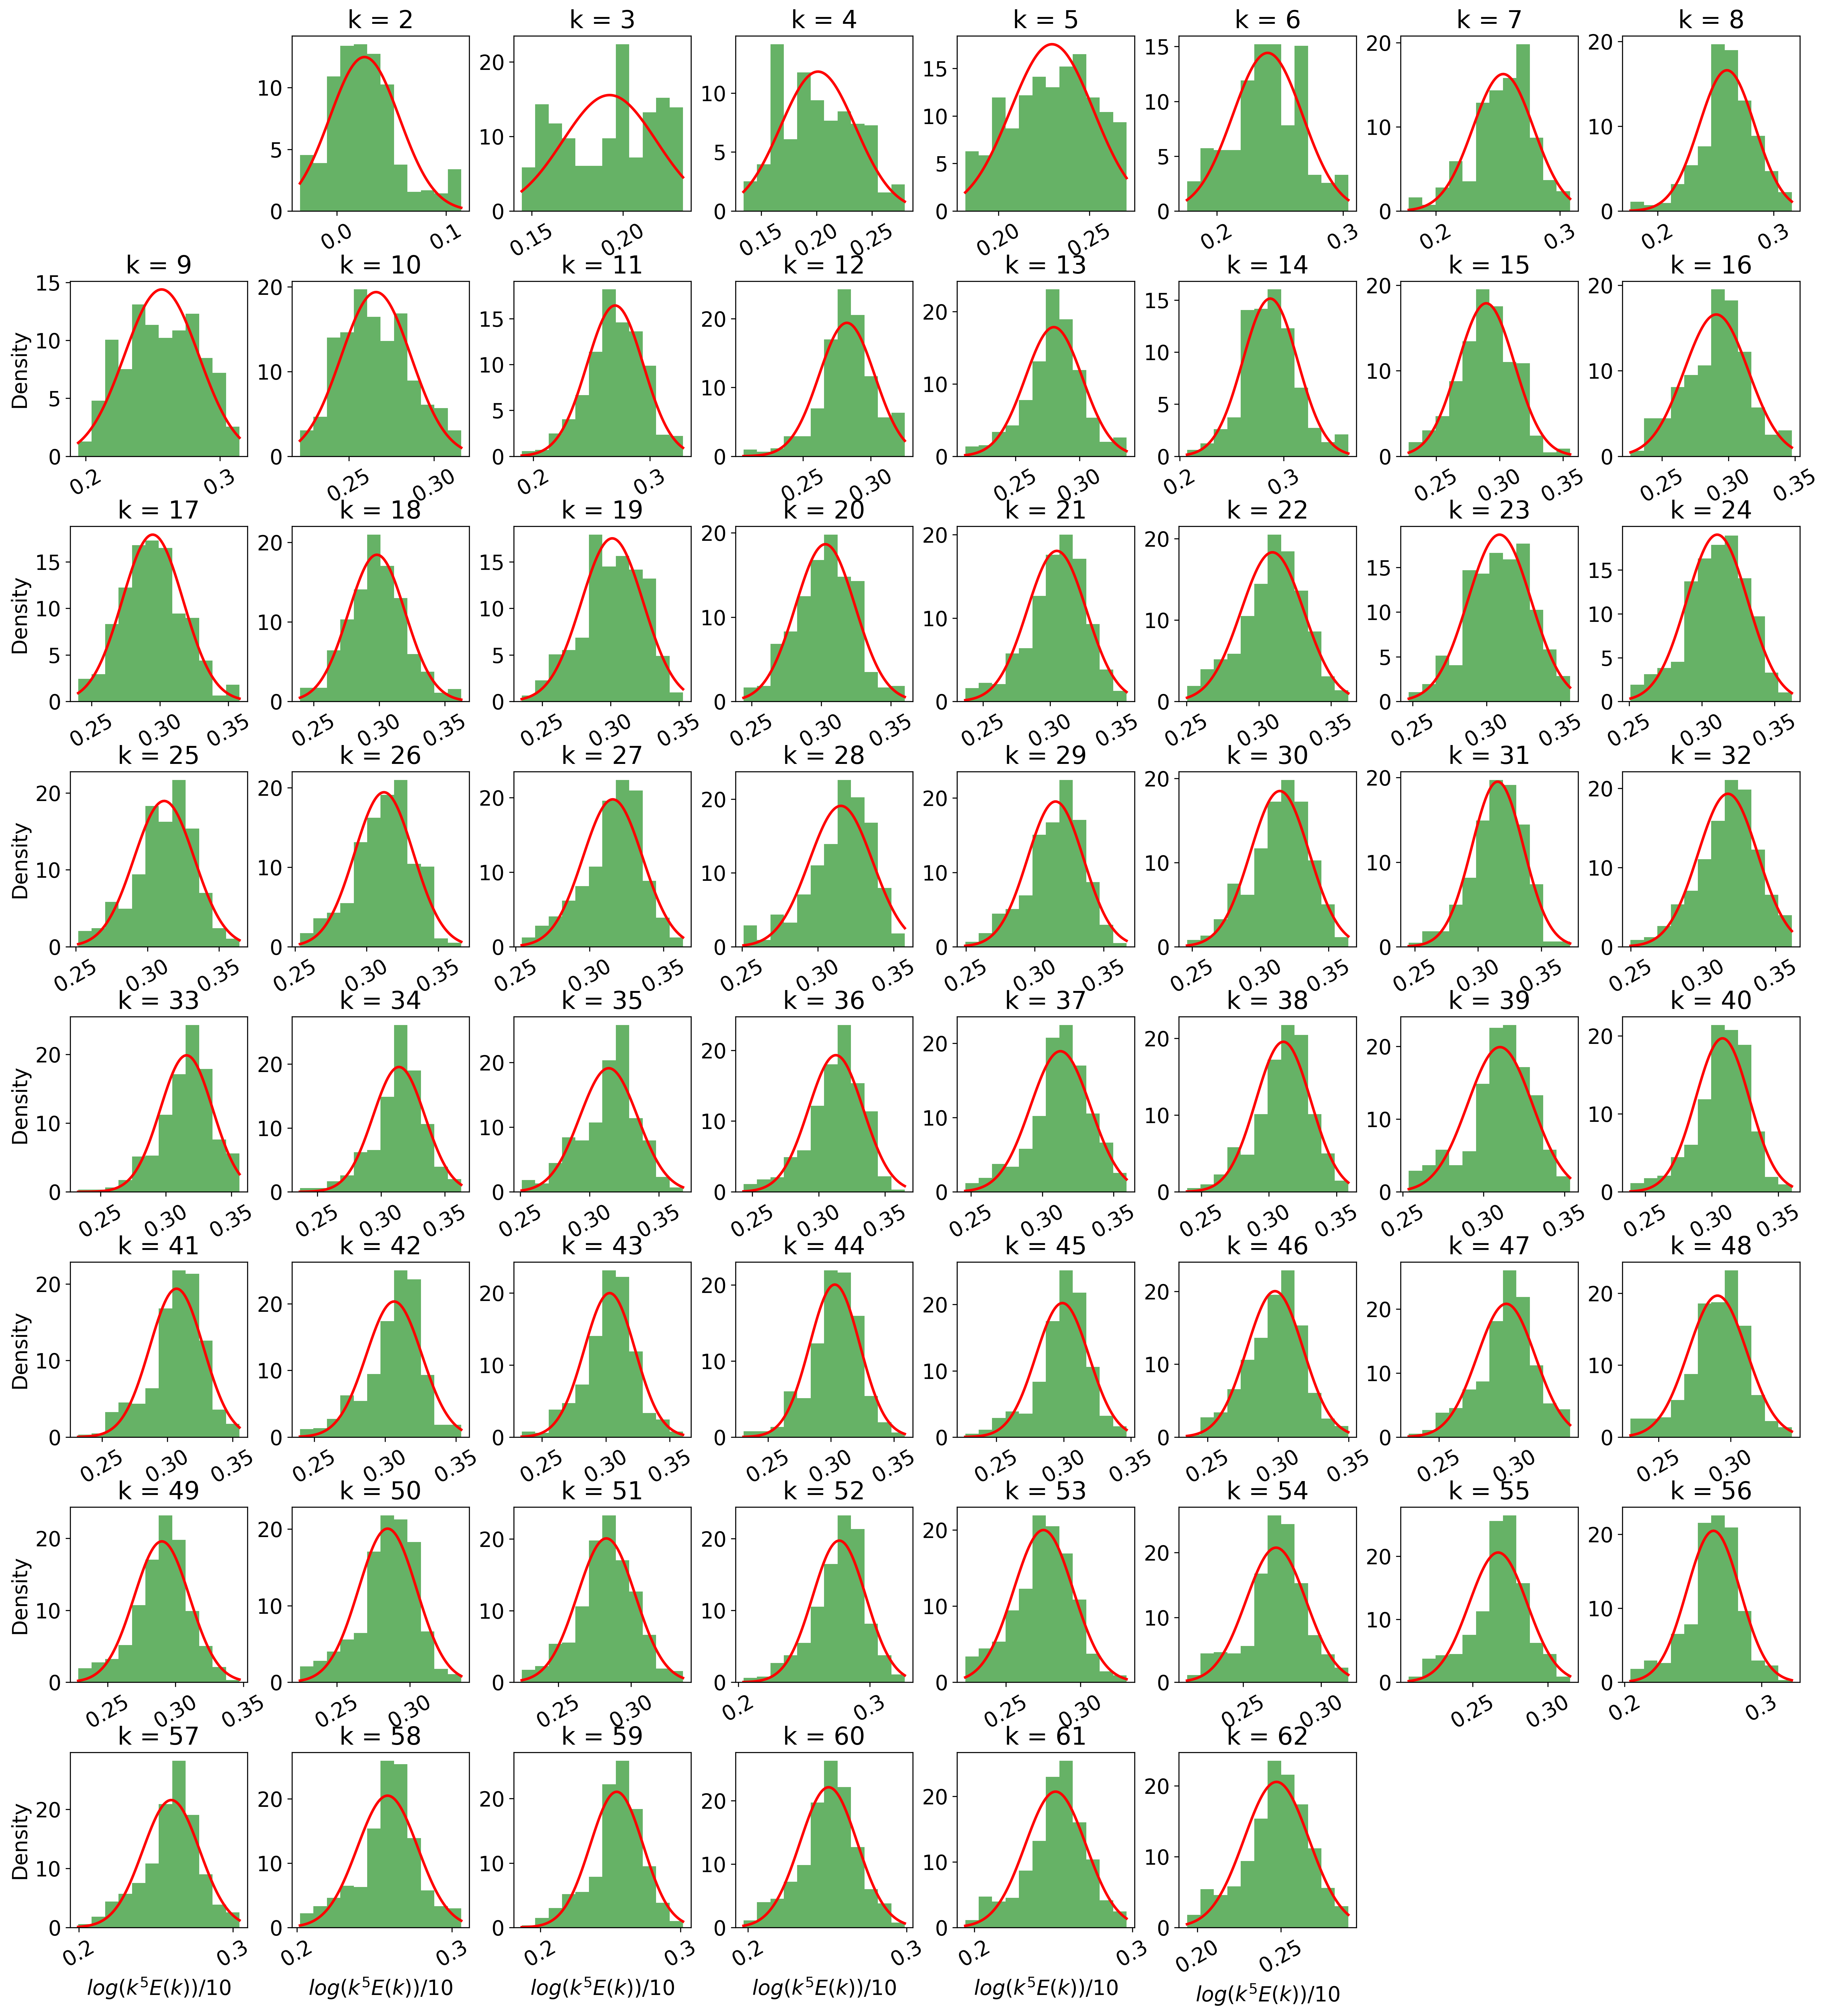

In [36]:
test_directory = 're10000_T227_S33_Kolmogorov_runs/'

subfolders = [name for name in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, name))]
subfolders = np.sort(subfolders)

# Sort folders with custom key
subfolders = sorted(subfolders, key=custom_sort_key)

names = ["128_BGK",
         "128_glob",
         "128_interp",
         "128_loc",
         "128_KBC",
         "256_BGK",
         "2048_BGK"]

paths = [test_directory+subfolder+"/" for subfolder in subfolders]

#load all velocity files for all paths, and compute vorticity correlation
images = [get_names(path) for path in paths]
N = len(paths)
M = len(images[0])-1


#compute enerty spectrum statistics
L = int(128/2 - 1)
a = 1
b = M-1
spec = np.zeros((N, L, (b-a)))
k = np.arange(L)


scaled_spec = np.zeros((L-1, (b-a)))
spec = np.zeros((L-1, (b-a)))
for i in tqdm(range(a, b)):
    velocities = np.array(np.load(paths[-1]+'/'+images[-1][i]))
    for j in range(N):
        _, E = energy_spectrum_2d(velocities)
        scaled_spec[:,i-a] = np.log((E[1:]*k[1:]**5))/10
        spec[:,i-a] = E[1:]

scaled_std = spec.std(axis=-1)
# Set the number of rows and columns for the grid
n_cols = 8  # Number of columns in the grid
n_rows = (63 // n_cols) + 1  # Number of rows, round up if necessary

# Set global font size
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(20, 22), dpi=300)

for i in range(1, 62):
    # Select the data for the current histogram
    data = scaled_spec[i, :]

    # Compute the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)

    # Create a subplot
    ax = plt.subplot(n_rows, n_cols, i + 1)

    # Plot normalized histogram
    counts, bins, _ = plt.hist(data, bins=12, density=True, alpha=0.6, color='g')

    # Generate points for the Gaussian curve
    x = np.linspace(bins[0], bins[-1], 100)
    y = norm.pdf(x, mean, std_dev)

    # Plot the Gaussian curve
    plt.plot(x, y, 'r-', linewidth=2)

    # Add title
    plt.title(f'k = {i + 1}')

    # Add x-labels only for plots in the last row
    if (i // n_cols) == (n_rows - 1):  # Last row check
        plt.xlabel(r'$log(k^5 E(k))/10$')

    # Add y-labels only for plots in the first column
    if (i % n_cols) == 0:  # First column check
        plt.ylabel('Density')

    # Rotate x-axis labels to prevent overlap
    plt.xticks(rotation=30)
    plt.yticks()

plt.tight_layout()  # Adjust layout to prevent overlap

# Reduce white space between subplots
plt.subplots_adjust(wspace=0.25, hspace=0.40)  # Adjust as needed

plt.show()